## Authors
 - João Louro
 - Bharati A
 - Shubam Jangir

## External links and resources
 - Shapefiles of Portuguese parishes - https://dados.gov.pt/pt/datasets/r/5474087d-7a14-4368-a9b8-3de751dca65a. We wanted our suggestions to be enforceable by an authority, and the parish was the most granular level for which we found polygon data. We also use shapefiles of districts for EDA
 - Dataset with location and population of the main portuguese towns - https://simplemaps.com/data/pt-cities. Important for our model, which predicts ad viewership
 - World Countries Shape files - simply being used to generate random coordinates inside the Portuguese border:
    - https://drive.google.com/file/d/1-5sz0ShpKOQYQxf5e2r74pHa4N8kpuZ4/view?usp=sharing
    - https://drive.google.com/file/d/1-7NDGyKlSWCSMehjRNL1xB539V-UxxEg/view?usp=sharing
    - https://drive.google.com/file/d/1-9U_TwmMLYgxJO7pWGQO7hS-2H8IsI5R/view?usp=sharing
    - https://drive.google.com/file/d/1-9ut6Mk_hsvONZYU4QBULW8YOZHPvkqO/view?usp=sharing
    - https://drive.google.com/file/d/1-MMCmzK8-SZemwYKhE9D9I4vhyxzFXOd/view?usp=sharing
    - https://drive.google.com/file/d/18HJ9RiU_SrQovgzSJO_fpQWCmzPLuB0E/view?usp=sharing

## Introduction

We believe the simplest way to reduce the visual impact of outdoor advertising in cities is to reduce the number of advertisements in the most ad-crowded areas. We start by considering that the areas of Portugal with the highest density of outdoor advertisements are already too crowded. Our solution porposes the relocation of a number of advertisements from the most crowded areas to regions with untapped viewership potential. We also theorize that, even if absolute viewership decreases, having these billboards further away from other forms of advertising will increase their impact, all while keeping the overall impact in public spaces low.

Our apporoach can be then divided into 4 steps:
 1. Identifying the parishes which are too advertisement-crowded, and limit the number of advertisement in those parishes
 2. Based on the advertisement data we do have, create a model capable of predicting the average daily viewership for an ad placed in any point in mainland Portugal
 3. Make our model predict the viewership of many points (randomly) scattered across Portugal
 4. Decide on which of the randomly scattered points should the outdoor advertisements we removed from the crowded areas be moved to
    - The decision on how to best move the points is not based simply on total viewership, but on a slightly more complex objective function. In order to prevent concentration of advertising in cities, ad placements are by multiplying their viewership by a "remoteness factor", which is higher for points further away from the main cities

One thing that must be noted is that this "movement"of banners would not be enforced by a central authority. What we are simulating with this approach is that a limit to the number of banners in city centres would mean a number of them would not be there, and would likely be placed in differet locations instead. We then try and propose good locations to move these banners, and try to estimate the impact of these measures to advertisers in a data-driven manner.

## Development

We start by presenting the functions we use in the code, so that the notebook is easier to read.

In [1]:
def count_banners_district_parish():
    district_num_banners = {}
    ads_coords = list(ads.geometry)
    for _, district in tqdm(districts.iterrows(), total=len(districts)):
        district_num_banners[district.NAME_1]  = 0
        for ad in ads_coords:
            if ad.within(district.geometry):
                district_num_banners[district.NAME_1] += 1
    
    data = []
    for district, n_banners in district_num_banners.items():
        data.append([district, n_banners])
    district_banners = pd.DataFrame(data, columns=['District', 'n_banners'])
    
    district_banners.to_csv('district_banners.csv', index=False)
    
    parish_num_banners = {}
    ads_coords = list(ads.geometry)
    for _, parish in tqdm(parishes.iterrows(), total=len(parishes)):
        parish_num_banners[parish.NAME_3]  = 0
        for ad in ads_coords:
            if ad.within(parish.geometry):
                parish_num_banners[parish.NAME_3] += 1
    
    data = []
    for parish, n_banners in parish_num_banners.items():
        data.append([parish, n_banners])
    parish_banners = pd.DataFrame(data, columns=['Parish', 'n_banners'])
    
    parish_banners.to_csv('parish_banners.csv', index=False)
    
def generate_random_coordinates_portugal(n_points=1000):
    lats=[]
    lons=[]
    for i in tqdm(range(0,n_points)):
        point =random_point_in_country("random_points/World_Countries.shp", "Portugal")
        lats.append(point[0])
        lons.append(point[1])
    return pd.DataFrame({'X': lats, 'Y': lons})


# function that takes a shapefile location and a country name as inputs
def random_point_in_country(shp_location, country_name):
    shapes = shapefile.Reader(shp_location) # reading shapefile with pyshp library
    country = [s for s in shapes.records() if country_name in s][0] # getting feature(s) that match the country name 
    country_id = int(re.findall(r'\d+', str(country))[0]) # getting feature(s)'s id of that match

    shapeRecs = shapes.shapeRecords()
    feature = shapeRecs[country_id].shape.__geo_interface__

    shp_geom = shape(feature)

    minx, miny, maxx, maxy = shp_geom.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if shp_geom.contains(p):
            return p.x, p.y
        
        
# for population feature        
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]


In [2]:
def closest_point_on_haversine(point,edge):
    closest_point = None
    for c in edge[0].coords:
        if closest_point == None:
            closest_point = haversine(tuple(reversed(point)), c, unit='m')
        else:
            if haversine(tuple(reversed(point)), c, unit='m') < closest_point:
                closest_point = haversine(tuple(reversed(point)), c, unit='m')       
    return closest_point

def distance_from_highway(row):
    lat = row['Y']
    lon = row['X']
    
    closest_highway_dist = np.inf
    
    # 2 km vicinity
    try:
        G = ox.graph_from_point((lat,lon), dist=1000, network_type='drive')
    except:
        return closest_highway_dist
    
    # Convert Graph to graph data frame
    gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
    
    # extract roads and some properties
    roads = gdf[["geometry","highway"]].values.tolist()
    
    filtered_roads = list(filter(lambda r: (r[1]=='motorway') or (r[1]=='primary'), roads))
    
    # calculate and attach distance
    roads_with_distances = [(road, closest_point_on_haversine((lat, lon), road)) for road in filtered_roads]
    
    #sort by distance
    roads_with_distances = sorted(roads_with_distances, key=lambda x: x[1])
    
    # Select closest road
    if roads_with_distances:
        closest_highway_dist = roads_with_distances[0][1]
    
    return closest_highway_dist

In [3]:
def add_features_to_coords(points):
    for _, dist_cap in cities[cities.city.isin(['Lisbon', 'Porto', 'Coimbra', 'Faro'])].iterrows():
    #or _, dist_cap in cities[cities.capital=='admin'].iterrows():
        dist_cap_coord = (dist_cap.lng, dist_cap.lat)
        points[f'dist_{dist_cap.city}'] = points.apply(lambda x: haversine.haversine((x.X, x.Y), dist_cap_coord), axis=1)
    return points

In [89]:
# In section of the code, we explored an alternative to the "remoteness factor", 
# where we tried to optimize an "objective function" dependent of viewership of 
# banners and the entropy of their location (higher when they're spread out). It
# used the MH algorithm to optimize them objective function. It is not currently
# being used in the code, but is an approach we believe has potential as well.

def entropy_func(df):
    df_keep = data[data['keep']==1][['Y','X']]
    X = np.array(df_keep)
    
    ## estimate pdf using KDE with gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
    
    log_p = kde.score_samples(X)  # returns log(p) of data sample
    p = np.exp(log_p)                # estimate p of data sample
    
    entropy = -np.sum(p*log_p)       # evaluate entropy

    return entropy

def objective_func(df, a=0.5, b=0.5, c = 1e7, max_locations = 1000):
    # Only keep active locations
    df_keep = df[df['keep']==1]
    
    # a is weightage for viewership
    # b is weightage for entropy
    # a+b = 1
    
    viewership = df_keep['Predicted_daily_views'].sum()
    entropy = entropy_func(df_keep)
    
    # Penalty if number of active locations cross the max count
    count_locations = df_keep['keep'].sum()
    penalty_flag = count_locations > max_locations
    
    val = a*viewership + b*entropy - c*penalty_flag
    
    return val

def main_func(df, val_exist, p, beta = 1.0):
    # number of locations
    n_locations = len(df)
    
    # Calculate existing cost
    #val_exist = objective_func(x)
    
    # Take y random (uniform)
    # Now proposed state
    y = np.round(np.random.binomial(1,p,size=n_locations)).astype(int)
    
    df_future = df.copy()
    df_future['keep'] = y
    
    # Calculate future obj function value
    val_future = objective_func(df_future)
    
    # Now check if future objective func value is more than the previous
    if (val_future > val_exist):
        # Accept it
        df = df_future.copy()
        val_exist = val_future
    else:
        # Accept it with e^(beta*(val_future-val_exist))
        prob = np.exp(beta*(val_future-val_exist))
        rand = np.random.uniform(0,1)
        if (rand<=prob):
            # Accept it
            df = df_future.copy()
            val_exist = val_future
        # else pass
        
    return df, val_exist

def mh_algo(df, val_exist, p, steps=100):
    '''
    Takes a starting distribution array, and the number of steps the iteration will run
    Returns - distribution coverage (number of locations with positive), and final objective function value
    '''
    dist_cover = 0
    objective_val = 0
    
    val_arr = []
    
    # Iterations
    for i in tqdm(range(steps)):
        #print(val_exist)
        val_arr.append(val_exist)
        df, val_exist = main_func(df, val_exist, p)
    
    return df, val_arr

### Imports

In [6]:
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from tqdm import tqdm
import haversine
from pandarallel import pandarallel
import osmnx as ox
import re
import random
import shapefile
from shapely.geometry import shape, Point
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import folium
import pandas as pd
import math
import folium.plugins
import branca
import branca.colormap as cm

In [ ]:
!wget https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_PRT_shp.zip -q
!unzip gadm36_PRT_shp.zip 

# Simple EDA of the provided data

In [ ]:
!wget https://wdl-data.fra1.digitaloceanspaces.com/pse/outdoor_inventory.zip -q
!unzip outdoor_inventory.zip

In [7]:
ads = gpd.read_file("Outdoor_Inventory_AV.shp")

In [8]:
ads

PanelID         X          Y  Max_Visibi  Average_Da  \
0        26144 -8.473975  40.900768          69        31.0   
1        11714 -9.315949  38.958125          69        31.0   
2        26109 -8.510079  40.871821          69        32.0   
3        32555 -8.479751  40.837695          69        32.0   
4         5291 -8.429870  40.268692          69        32.0   
...        ...       ...        ...         ...         ...   
30370     4671 -9.415045  38.701264         145     71045.0   
30371     4676 -9.415113  38.701244         145     73035.0   
30372    32007 -9.171094  38.703705         180     76575.0   
30373    29984 -9.165918  38.750425         180     79714.0   
30374    48440 -8.432747  41.544365         180     81532.0   

                        geometry  
0      POINT (-8.47397 40.90077)  
1      POINT (-9.31595 38.95813)  
2      POINT (-8.51008 40.87182)  
3      POINT (-8.47975 40.83769)  
4      POINT (-8.42987 40.26869)  
...                          ...  
30370  POINT (-9.41504 38.70126)  
30371  POINT (-9.41511 38.70124)  
30372  POINT (-9.17109 38.70370)  
30373  POINT (-9.16592 38.75042)  
30374  POINT (-8.43275 41.54436)  

[30375 rows x 6 columns]

This dataset provides the location of advertisements across Portugal. We can start by plotting a heatmap.

In [575]:
fixed_pt_map = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )

In [ ]:
f = folium.Figure(width=400, height=700)
m = fixed_pt_map
   
heat_data = [[row['Y'],row['X']] for _, row in ads.iterrows()]
HeatMap(heat_data, radius=12).add_to(m)

f.add_child(m)
#f

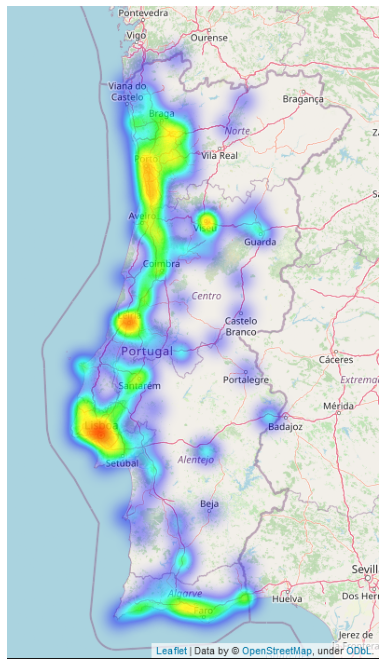

In [75]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/banners_heatmap.png")
plt.imshow(a)
plt.axis('off')
plt.show()

We can see outdoor advertisements are mainly distributed in the metropolitan areas of Lisbon and Oporto, with significant numbers in other cities, including some in the interior regions of the country. We'll now load the districts and parishes polygons, to provide an additional sense of the location of these advertisements.

In [12]:
districts = gpd.read_file('gadm36_PRT_1.shp')
parishes = gpd.read_file('gadm36_PRT_3.shp')

In order to get the number of banners for each district and parish, we can use the code in the **count_banners_district_parish** function at the start of the notebook. Since this code takes a while to run, we have previously loaded this data to github, and we'll instead read from that.

In [13]:
district_banners = pd.read_csv('https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/district_banners.csv')
parish_banners = pd.read_csv('https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/parish_banners.csv')

We'll then merge this data to our geodataframe containing the polygons, in order to ease our data exploration

In [14]:
districts = districts.merge(district_banners, left_on='NAME_1', right_on='District').drop(columns=['District'])
parishes = parishes.merge(parish_banners, left_on='NAME_3', right_on='Parish').drop(columns=['Parish'])

In [ ]:
f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
folium.Choropleth(districts, data=districts, 
                  key_on='feature.properties.NAME_1',
                  columns=['NAME_1', 'n_banners'], 
                  fill_color='YlOrBr').add_to(m)

folium.LayerControl().add_to(m)
f.add_child(m)
#f

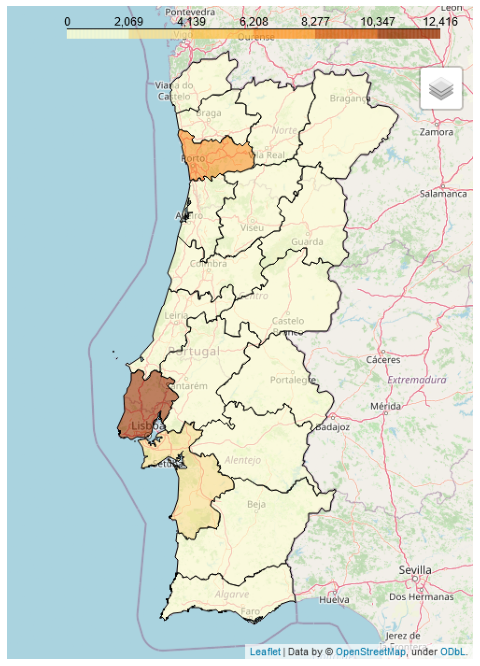

In [74]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/districts.png")
plt.imshow(a)
plt.axis('off')
plt.show()

The banners are mostly distributed around the metropolitan area of Lisbon (Lisbon and Setúbal districts) and the metropolitan area of Oporto.

In [ ]:
f = folium.Figure(width=500, height=500)
m = folium.Map(
    location=[38.736946, -9.142685],
    zoom_start=11,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
folium.Choropleth(parishes, data=parishes, 
                  key_on='feature.properties.GID_3',
                  columns=['GID_3', 'n_banners'],
                  fill_color='YlOrBr').add_to(m)

folium.LayerControl().add_to(m)
f.add_child(m)
f

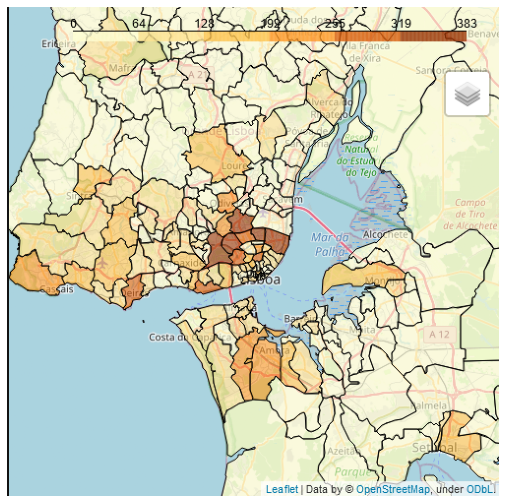

In [77]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(9,9))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/lisbon_parishes.png")
plt.imshow(a)
plt.axis('off')
plt.show()

We can alse see the concentration of banners is much greater in some parishes than in others. We intuitively believe that banners would be more disruptive in these areas, and we propose a reduction of the concentration of advertisements in these specific parishes.

Having these limitations at a parish level makes them very enforceable, since there are well-defined "chains of command" and borders are well established. Ideally, we would take action at an even more granular level (e.g. neighbourhood or street), but in order to maintain a data-driven approach, we have decided to base ourselves on the parish, since we have polygon data available (while this is not available for neighbourhoods). The fact that borders between neighbourhoods are often not clear-cut could lead to confusion when trying to limit the number of ads.

In [ ]:
f = folium.Figure(width=500, height=500)
m = folium.Map(
    location=[41.1579438, -8.6291053],
    zoom_start=11,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
folium.Choropleth(parishes, data=parishes, 
                  key_on='feature.properties.GID_3',
                  columns=['GID_3', 'n_banners'],
                  fill_color='YlOrBr').add_to(m)

folium.LayerControl().add_to(m)
f.add_child(m)
f

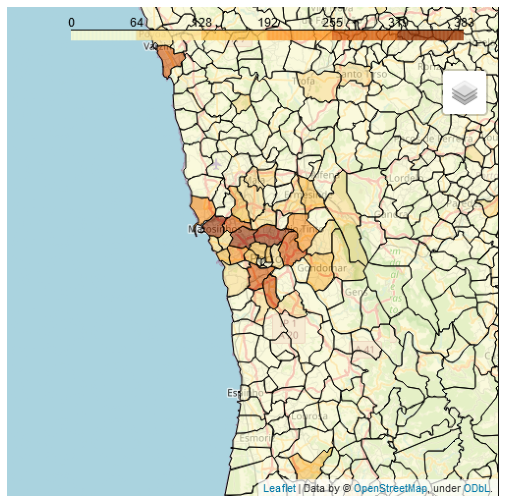

In [78]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(9,9))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/Porto_parishes.png")
plt.imshow(a)
plt.axis('off')
plt.show()

# Step 1 - Banner Concentration Limit

We believe the most effective way to reduce the visual impact of ads in cities is to reduce their number. In parallel, we would suggest other approaches as well, such as uniformizing the placement of outdoor banners. In order to provide actionable results in a data-driven manner, we start by calculating the concentration of banners (number/area) for each parish. We also propose a limit number of banners by area. For each parish, there will therefore be a limit number of ads, above which the placement of more banners will not be allowed. 

In our approach, we are essentially removing a number of ads from the most ad-crowded areas of Lisbon. We will then propose other places for these banners. In a real-world scenarion, the changes in placement of banners would always be decided by advertisers. However, and in order to study the impacts of our approach, we will simulate the removal of the ones with the least vieweship for each of the affected parishes, and their translation to new locations.

We start by calculating the area of each parish, from its polygon.

In [ ]:
parishes['geometry'] = parishes.geometry.to_crs({'init': 'epsg:3857'})
parishes["area"] = parishes['geometry'].area

In [21]:
parishes['banners_per_area'] = parishes.n_banners/ parishes.area

In [23]:
parishes.sort_values('banners_per_area', ascending=False).head(10)

GID_0    NAME_0     GID_1   NAME_1 NL_NAME_1       GID_2   NAME_2  \
2022   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2760   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2724   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2751   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
1846   PRT  Portugal   PRT.7_1  Coimbra      None   PRT.7.3_1  Coimbra   
2757   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2750   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2752   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2745   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   
2758   PRT  Portugal  PRT.12_1   Lisboa      None  PRT.12.7_1   Lisboa   

     NL_NAME_2          GID_3                     NAME_3 VARNAME_3 NL_NAME_3  \
2022      None  PRT.12.7.31_1                Santa Justa      None      None   
2760      None  PRT.12.7.52_1                         Sé      None      None   
2724      None  PRT.12.7.14_1           Coração De Jesus      None      None   
2751      None  PRT.12.7.44_1       São Jorge De Arroios      None      None   
1846      None   PRT.7.3.14_1   Coimbra (São Bartolomeu)      None      None   
2757      None  PRT.12.7.49_1                  São Paulo      None      None   
2750      None  PRT.12.7.43_1           São João De Deus      None      None   
2752      None  PRT.12.7.45_1                   São José      None      None   
2745      None  PRT.12.7.37_1             Santos-O-Velho      None      None   
2758      None  PRT.12.7.50_1  São Sebastião Da Pedreira      None      None   

      TYPE_3 ENGTYPE_3  CC_3 HASC_3  \
2022  Parish    Parish  None   None   
2760  Parish    Parish  None   None   
2724  Parish    Parish  None   None   
2751  Parish    Parish  None   None   
1846  Parish    Parish  None   None   
2757  Parish    Parish  None   None   
2750  Parish    Parish  None   None   
2752  Parish    Parish  None   None   
2745  Parish    Parish  None   None   
2758  Parish    Parish  None   None   

                                               geometry  n_banners  \
2022  POLYGON ((-1017847.571 4680939.418, -1017842.2...        137   
2760  POLYGON ((-1016240.058 4679975.074, -1016251.0...         51   
2724  POLYGON ((-1017744.275 4682112.862, -1017749.5...        183   
2751  POLYGON ((-1017826.763 4682563.553, -1017892.0...        261   
1846  POLYGON ((-938492.241 4895908.680, -938523.453...         37   
2757  MULTIPOLYGON (((-1018920.131 4680099.694, -101...         92   
2750  POLYGON ((-1016777.240 4684080.698, -1016852.2...        192   
2752  POLYGON ((-1018333.159 4681091.261, -1018323.3...         63   
2745  POLYGON ((-1019866.995 4679950.586, -1019856.5...         90   
2758  POLYGON ((-1019287.135 4682343.648, -1019305.9...        188   

              area  banners_per_area  
2022  4.034781e+05          0.000340  
2760  1.964603e+05          0.000260  
2724  9.211378e+05          0.000199  
2751  1.886816e+06          0.000138  
1846  2.871852e+05          0.000129  
2757  7.194508e+05          0.000128  
2750  1.528315e+06          0.000126  
2752  5.449727e+05          0.000116  
2745  8.461889e+05          0.000106  
2758  1.781397e+06          0.000106

To reiterate, we'll propose a limit to the number of outdoor advertisements per parish. Our specific posposal is to limit the number of banner to the concentration of banners in the São José parish. This cutoff decision is somewhat arbitrary here, and would have to be agreed upon by public officials and advertisers.

Our approach then proposes that no parish should have a concentration of banners higher than the present concentration of the São José parish, in Lisbon.

In [24]:
BANNERS_CONCENTRATION_THRESHOLD = parishes[(parishes.NAME_3=='São José') & (parishes.NAME_1=='Lisboa')].iloc[0].banners_per_area

We can then calculate the number of allower banners for each parish if we take our threshold into consideration, as well as the number of banners that must be removed in every parish.

In [25]:
parishes['allowed_banners'] = (BANNERS_CONCENTRATION_THRESHOLD * parishes['area']).astype(int)
parishes['banners_to_remove'] = parishes.apply(lambda x: x['n_banners'] - x['allowed_banners'] if x['allowed_banners']<x['n_banners'] else 0, axis=1)

Below, you can see the a graph rerpesenting number of banners to be removed from each parish in Lisbon.

In [ ]:
f = folium.Figure(width=400, height=700)
m = folium.Map(
    location=[38.736946, -9.142685],
    zoom_start=12,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
folium.Choropleth(parishes, data=parishes, 
                  key_on='feature.properties.GID_3',
                  columns=['GID_3', 'banners_to_remove'], 
                  fill_color='YlOrRd').add_to(m)

folium.LayerControl().add_to(m)
f.add_child(m)
f

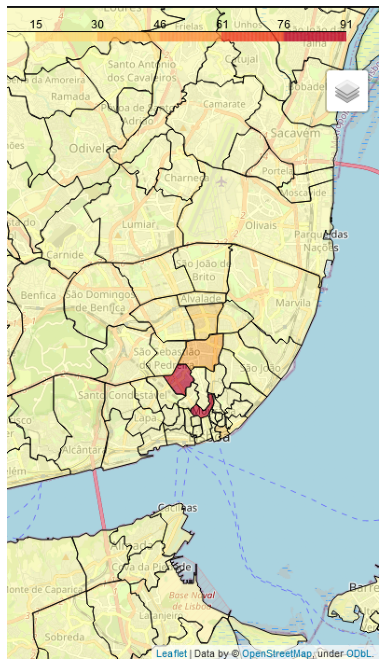

In [81]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/remove_from_parish.png")
plt.imshow(a)
plt.axis('off')
plt.show()

We can now identify the banners with lower viewership on the most crowded parishes. These are the specific banners we propose to be removed.

In [ ]:
parishes.geometry= parishes.geometry.to_crs({'init': 'epsg:3857'})
ads.geometry= ads.geometry.to_crs({'init': 'epsg:3857'})

In [28]:
ads_to_remove = pd.DataFrame(columns = ads.columns)
for _, parish in parishes[parishes.banners_to_remove > 0].iterrows():
    parish_ads = pd.DataFrame(columns = ads.columns)
    parish_ads_list = []
    for _, ad in ads.iterrows():
        if ad.geometry.within(parish.geometry):
            parish_ads_list.append(ad.values)
    parish_ads = parish_ads.append(pd.DataFrame(parish_ads_list, columns=parish_ads.columns)).reset_index()
    parish_ads = parish_ads.sort_values('Average_Da', ascending=False).head(parish.banners_to_remove)
    ads_to_remove = pd.concat([ads_to_remove, parish_ads])

These are the specific banners we will remove from ad-crowded city centres. They are 250 in total.

In [785]:
ads_to_remove

PanelID         X          Y Max_Visibi  Average_Da  \
36     4906 -8.429925  40.206943         75     32259.0   
35     4905 -8.429925  40.206943         75     31304.0   
34     4947 -8.430083  40.207451         69     18735.0   
33     1067 -8.429588  40.207490         69     17620.5   
136   24629 -9.136058  38.715382         69     17204.0   
..      ...       ...        ...        ...         ...   
4     23324 -9.132330  38.710175         69      5258.0   
3     23493 -9.134206  38.710056         69      3026.0   
2     24254 -9.133770  38.709762         69      2253.0   
1     24255 -9.133767  38.709761         69      1877.0   
0     23492 -9.134204  38.710054         69      1068.0   

                                         geometry  index  
36   POINT (-938414.9584254868 4896060.400265037)   36.0  
35   POINT (-938414.9584254868 4896060.400265037)   35.0  
34      POINT (-938432.546905032 4896134.4466113)   34.0  
33   POINT (-938377.4437570896 4896140.131294678)   33.0  
136  POINT (-1017021.324417813 4680984.099387572)  136.0  
..                                            ...    ...  
4    POINT (-1016606.325356136 4680241.247512949)    4.0  
3    POINT (-1016815.160720864 4680224.271119615)    3.0  
2    POINT (-1016766.625422878 4680182.329563116)    2.0  
1    POINT (-1016766.291464406 4680182.186905054)    1.0  
0    POINT (-1016814.938081883 4680223.985802322)    0.0  

[250 rows x 7 columns]

We can also visualize the banners to be removed nationally with a heatmap.

In [ ]:
f = folium.Figure(width=400, height=700)
m = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
   
heat_data = [[row['Y'],row['X']] for _, row in ads_to_remove.iterrows()]
HeatMap(heat_data, radius=12).add_to(m)

f.add_child(m)
f

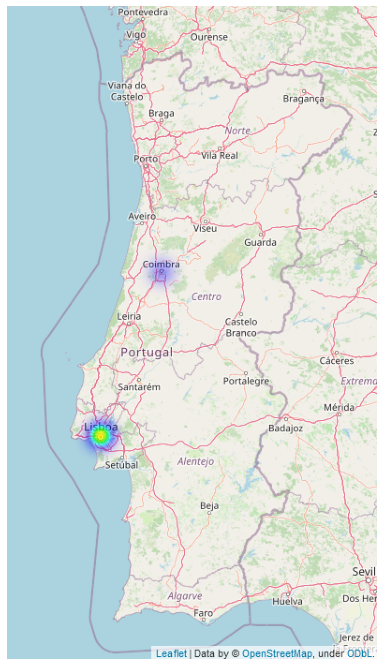

In [83]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/banners_to_remove.png")
plt.imshow(a)
plt.axis('off')
plt.show()

We can see that, if our concept of banner concentration limits were applied, there would be banners removed from the cities of Lisbon and Coimbra. The city with the greatest reduction would be Lisbon. In order to take our concept further, we must now find suitable placements for the ads removed from these cities. For that, we'll start by trying to develop a model to predict the viewership of any location in Portugal.

# Step 2 - Model to predict viewership for a location

We now propose a simple model to prodict the viewership for an ad placed in any location. A model of this kind can become very complex, and if someone had a good model of this kind, they would stand to make a lot of money :) In this case we are presenting a relatively simple proof of context. Our 4-set approach is modular, and parts of it can be improved in separate.

Initially, we have essentially no features to use that could be used to a model. We'll then try and derive features from the location data. Having good features will be of crucial importance for this model to be powerful. There are several paid APIs which would provide great information, but which we are not using in this case.

We'll start with a very simple set of features: distance of each banner to Coimbra, Porto, Faro and Lisbon. For that, we use an external dataset with locations and population of Portuguese towns.

In [31]:
cities = pd.read_csv('pt.csv')
# Getting points geometry from lat and long columns
cities = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lat, cities.lng))
cities.head(4)

city      lat     lng   country iso2 admin_name  capital  \
0             Lisbon  38.7452 -9.1604  Portugal   PT     Lisboa  primary   
1  Vila Nova de Gaia  41.1333 -8.6167  Portugal   PT      Porto    minor   
2              Porto  41.1495 -8.6108  Portugal   PT      Porto    admin   
3              Braga  41.5333 -8.4167  Portugal   PT      Braga    admin   

   population  population_proper                   geometry  
0    506654.0           506654.0  POINT (38.74520 -9.16040)  
1    302295.0           302295.0  POINT (41.13330 -8.61670)  
2    237591.0           237591.0  POINT (41.14950 -8.61080)  
3    181494.0           181494.0  POINT (41.53330 -8.41670)

We now add the distance of each point to the district capitals. In this **cities** dataset, the cities with value **admin** on the **capital** column are the district capitals. There are 18 district capitals on mainland Portugal, so this will add 18 columns to our dataset

In [32]:
#for _, dist_cap in cities[cities.capital=='admin'].iterrows():
for _, dist_cap in cities[cities.city.isin(['Lisbon', 'Porto', 'Coimbra', 'Faro'])].iterrows():
    dist_cap_coord = (dist_cap.lng, dist_cap.lat)
    ads[f'dist_{dist_cap.city}'] = ads.apply(lambda x: haversine.haversine((x.X, x.Y), dist_cap_coord), axis=1)

In [33]:
ads.head(4)

PanelID         X          Y  Max_Visibi  Average_Da  \
0    26144 -8.473975  40.900768          69        31.0   
1    11714 -9.315949  38.958125          69        31.0   
2    26109 -8.510079  40.871821          69        32.0   
3    32555 -8.479751  40.837695          69        32.0   

                           geometry  dist_Lisbon  dist_Porto  dist_Coimbra  \
0   POINT (-943318.582 4997715.966)   248.848799   31.297728     76.018834   
1  POINT (-1037046.699 4715675.112)    29.073645  253.141955    169.333200   
2   POINT (-947337.661 4993453.635)   244.595836   32.521831     73.223430   
3   POINT (-943961.563 4988431.109)   242.058454   37.254426     69.146885   

    dist_Faro  
0  431.673523  
1  263.039000  
2  429.081362  
3  424.889054

Our **ads** dataset includes now the distance of the banner to each of the district capitals, in kilometers. We have now enough for a baseline model. We start by preparing our dataset to be fed into a model.

In [34]:
train =  ads.drop(columns=['PanelID', 'X', 'Y', 'Max_Visibi', 'geometry', 'Average_Da'])
y = ads.Average_Da.values
x = train.values

We then split into a train and test model, leaving 20% of the data as a test (validation, really) dataset. We'll use this test dataset to evaluate our results.

In [35]:
# Create training and validation sets
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

# Create the LightGBM data containers
categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
train_data = lightgbm.Dataset(x, label=y)
test_data = lightgbm.Dataset(x_test, label=y_test)

In [36]:
# Train the model
parameters = {
    'objective': 'regression',
    'metric': 'RMSE',
    'boosting': 'gbdt',
    'num_tree':10000,
    'num_leaves': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.1,
    'verbose': -1, 
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=50000,
                       early_stopping_rounds=1000,
                       verbose_eval=1000)

/home/primity/.miniconda3/envs/eruditio/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_tree` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[1000]	valid_0's rmse: 4940.62
[2000]	valid_0's rmse: 4932.38
[3000]	valid_0's rmse: 4917.07
[4000]	valid_0's rmse: 4940.31
Early stopping, best iteration is:
[3619]	valid_0's rmse: 4888.84


Given the **cities** dataset, we can add some population indicators to our data. A feature we believe would be useful would be the population of the nearest city to the banner. This would give us the indication if we are close to a large city, or if we are relatively far from large cities, and the nearest cities are relatively small.

In [37]:
cities = cities[cities.population.notnull()]
cities_with_population =cities

cities['point'] = [(x, y) for x,y in zip(cities_with_population['lat'], cities_with_population['lng'])]
ads['point'] = [(x, y) for x,y in zip(ads['Y'], ads['X'])]

ads['closest'] = [closest_point(x, list(cities_with_population['point'])) for x in ads['point']]
ads['nearest_town_population'] = [match_value(cities_with_population, 'point', x, 'population') for x in ads['closest']]

We have now added a **nearest_town_population** column to our data, which should inprove the predictions of our model.

In [38]:
ads.head(4)

PanelID         X          Y  Max_Visibi  Average_Da  \
0    26144 -8.473975  40.900768          69        31.0   
1    11714 -9.315949  38.958125          69        31.0   
2    26109 -8.510079  40.871821          69        32.0   
3    32555 -8.479751  40.837695          69        32.0   

                           geometry  dist_Lisbon  dist_Porto  dist_Coimbra  \
0   POINT (-943318.582 4997715.966)   248.848799   31.297728     76.018834   
1  POINT (-1037046.699 4715675.112)    29.073645  253.141955    169.333200   
2   POINT (-947337.661 4993453.635)   244.595836   32.521831     73.223430   
3   POINT (-943961.563 4988431.109)   242.058454   37.254426     69.146885   

    dist_Faro                   point             closest  \
0  431.673523  (40.900768, -8.473975)        (40.9, -8.5)   
1  263.039000  (38.958125, -9.315949)  (38.9333, -9.3333)   
2  429.081362  (40.871821, -8.510079)        (40.9, -8.5)   
3  424.889054  (40.837695, -8.479751)        (40.9, -8.5)   

   nearest_town_population  
0                  21713.0  
1                  76685.0  
2                  21713.0  
3                  21713.0

In [39]:
train =  ads.drop(columns=['PanelID', 'X', 'Y', 'Max_Visibi', 'geometry', 'Average_Da', 'point', 'closest'])
y = ads.Average_Da.values
x = train.values

In [40]:
# Create training and validation sets
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

# Create the LightGBM data containers
categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
train_data = lightgbm.Dataset(x, label=y)
test_data = lightgbm.Dataset(x_test, label=y_test)

In [41]:
# Train the model
parameters = {
    'objective': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.1,
    'verbose': -1, 
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=50000,
                       early_stopping_rounds=5000,
                       verbose_eval=1000)

Training until validation scores don't improve for 5000 rounds
[1000]	valid_0's rmse: 4883.62
[2000]	valid_0's rmse: 4865.59
[3000]	valid_0's rmse: 4848.02
[4000]	valid_0's rmse: 4871.88
[5000]	valid_0's rmse: 4867.09
[6000]	valid_0's rmse: 4879.6
[7000]	valid_0's rmse: 4865.92
[8000]	valid_0's rmse: 4863.04
Early stopping, best iteration is:
[3342]	valid_0's rmse: 4813.93


We can see that this distance feature improved the results of our model. However, we can see the results are not too great. That was to be expected, since models of this kind would need many sources of external data, and here we are simply used location-based data. And location by itself is not a significant feature, since banners in larger cities are much more frequent, but have relatively similar numbers of viwership to those in smaller cities (save for some exceptions).

We can try adding other features, such as the distance to a highway, since intuitively highway banners tend to have better viewership than other banners in the same area. We tried to include this featue, but did manage to itget working for lack of time. In our attempt, we used the oxmnx library, which can provide a graph of the roads near a coordinate. We then tried to compute the distance between our coordinate and the closest point of one of the line strings in the graph (filtering first, in order to consider only the highways). In the end, this approach took a long time to compute, and we didn't get to optimizing it, so it was not included. Below you can see the road graph (with a window of 2km around a coordinate).

In [ ]:
ox.plot_graph(ox.graph_from_point((40.900768, -8.473975), dist=2000, network_type='drive'))

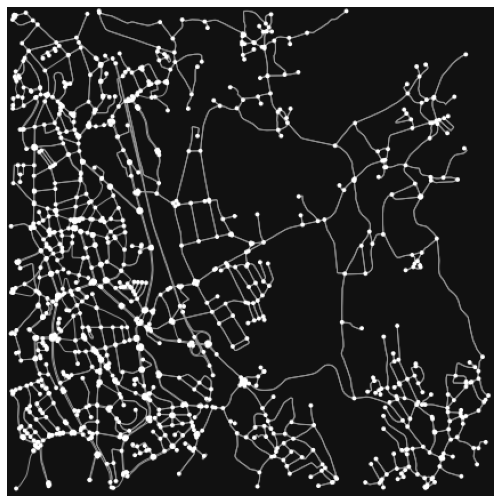

In [84]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(9,9))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/road_graph.png")
plt.imshow(a)
plt.axis('off')
plt.show()

In [426]:
# Trying a parallel computing library
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
#ads['highway_dist'] = ads.parallel_apply(distance_from_highway, axis=1)

# Step 3 - Inference in random points 

Now that we have a model capable of estimating the viewership of an ad placed in any location in the country, we can use it to discover potentially advantageous placements for ads, outside the major points of concentration. For that we'll start by getting a number of random points across Portugal, and we'll estimate the average daily viewership for those points. For that, we start by using an external library to generate close to 10 000 points across Portugal.

In [243]:
random_points = generate_random_coordinates_portugal(n_points=10000)

100%|██████████| 10000/10000 [07:26<00:00, 22.40it/s]


In [245]:
random_points= random_points[random_points.X>-10]

random_points.to_csv('random_pts_portugal.csv', index=False)

In [44]:
random_points=pd.read_csv('random_pts_portugal.csv')

Since the library is relatively slow, we can load the previously calculated points from a csv file. We can see these ad placement candidates are well scattered around the country.

In [ ]:
f = folium.Figure(width=400, height=700)
m = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
   
heat_data = [[row['Y'],row['X']] for _, row in random_points.iterrows()]
HeatMap(heat_data, radius=12).add_to(m)

f.add_child(m)
f

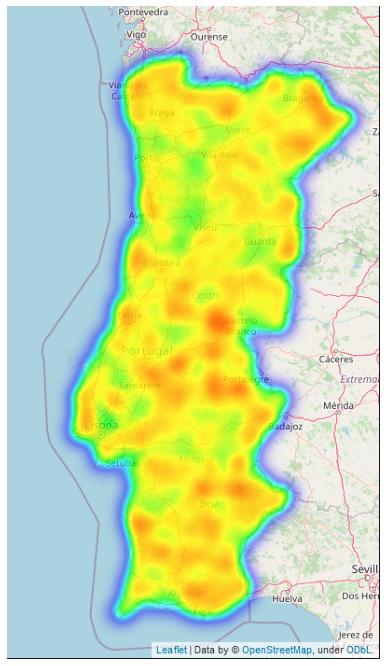

In [85]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/random_points.png")
plt.imshow(a)
plt.axis('off')
plt.show()

#### Predicting inference on Random Points

In order for our model to predict the viewership for the randomly generated points, we need to generate the features for the locations.

In [46]:
random_points = add_features_to_coords(random_points)

In [47]:
cities['point'] = [(x, y) for x,y in zip(cities_with_population['lat'], cities_with_population['lng'])]
random_points['point'] = [(x, y) for x,y in zip(random_points['Y'], random_points['X'])]

random_points['closest'] = [closest_point(x, list(cities_with_population['point'])) for x in random_points['point']]
random_points['nearest_town_population'] = [match_value(cities_with_population, 'point', x, 'population') for x in random_points['closest']]

In [48]:
random_points.head(3)

X          Y  dist_Lisbon  dist_Porto  dist_Coimbra   dist_Faro  \
0 -7.459289  37.345653   243.906539  437.943818    333.478624   63.969102   
1 -7.231791  38.771850   214.471882  303.446818    207.027750  208.590384   
2 -8.545714  39.309387    92.272069  202.451721    100.012078  261.330712   

                                     point            closest  \
0  (37.345652660694434, -7.45928853491375)   (37.2167, -7.45)   
1   (38.77185033660584, -7.23179105733551)   (38.88, -7.1628)   
2   (39.30938709326088, -8.54571376281178)  (39.2593, -8.585)   

   nearest_town_population  
0                   6747.0  
1                  20706.0  
2                   7702.0

In [49]:
x = random_points.drop(columns=['X', 'Y', 'point', 'closest']).values
y = model.predict(x)

In [50]:
random_points['Predicted_daily_views']=y

In [51]:
len(random_points)

9646

In [52]:
random_points

X          Y  dist_Lisbon  dist_Porto  dist_Coimbra   dist_Faro  \
0    -7.459289  37.345653   243.906539  437.943818    333.478624   63.969102   
1    -7.231791  38.771850   214.471882  303.446818    207.027750  208.590384   
2    -8.545714  39.309387    92.272069  202.451721    100.012078  261.330712   
3    -8.310807  41.264661   292.570507   35.681447    116.646915  469.491620   
4    -8.232695  38.438294   108.531900  301.169872    196.265807  160.005216   
...        ...        ...          ...         ...           ...         ...   
9641 -8.063295  41.328428   309.091250   63.983409    129.510004  474.996780   
9642 -8.661188  41.862782   346.943130   78.614079    183.444173  539.320781   
9643 -7.591435  41.033097   306.234955  114.070396    129.876075  444.138711   
9644 -8.125595  41.338507   307.429129   57.820414    128.564524  476.330173   
9645 -8.809929  37.103530   184.468616  445.251720    344.256508   97.943681   

                                         point             closest  \
0      (37.345652660694434, -7.45928853491375)    (37.2167, -7.45)   
1       (38.77185033660584, -7.23179105733551)    (38.88, -7.1628)   
2       (39.30938709326088, -8.54571376281178)   (39.2593, -8.585)   
3      (41.26466068473204, -8.310806879566027)  (41.2833, -8.2833)   
4     (38.438293661534594, -8.232694967061754)    (38.65, -8.2167)   
...                                        ...                 ...   
9641   (41.32842844308301, -8.063295360951791)  (41.2667, -8.0833)   
9642   (41.86278166913279, -8.661188079442159)  (41.7917, -8.5944)   
9643   (41.03309719814832, -7.591434958963799)  (40.9819, -7.6158)   
9644    (41.33850719494269, -8.12559537802252)  (41.3667, -8.1833)   
9645   (37.10352956407616, -8.809928554076432)  (37.0825, -8.9119)   

      nearest_town_population  Predicted_daily_views  
0                      6747.0           10664.408659  
1                     20706.0            2553.567147  
2                      7702.0            4651.025828  
3                     47387.0           13088.707053  
4                     17437.0            3761.757402  
...                       ...                    ...  
9641                  56264.0           20560.991689  
9642                   3932.0            4995.697885  
9643                  10212.0            3690.458101  
9644                  58065.0           12445.082920  
9645                   5258.0            3623.415747  

[9646 rows x 10 columns]

We now essentially have an estimation of ad viewership for the entire country. If we wanted to increase granularity, we could simply generate more random points to run inference on. If the model that estimates viewership is powerful, such an approach could lead to significant monetary gains for advertisers.

# Step 4 - Finding best locations to move banners

In order to try and find the best place to put our banners, we are not simply considering the estimated viwership. In order for the predictions to be moved further away from the main cities, we are also considering a "remoteness factor" which increases the prefenrence for places locations further away from lisbon, Porto and Coimbra. This is calculated by the sum of the log of the distances, multiplied by a factor which is larger for Lisbon and smaller form Coimbra. This makes the areas close to these cities less attractive

In [55]:
mlt={'Coimbra':2, 'Porto':3, 'Lisbon':4}
random_points['remoteness'] = 0
for _, dist_cap in cities[cities.city.isin(['Lisbon', 'Porto', 'Coimbra'])].iterrows():
    dist_cap_coord = (dist_cap.lng, dist_cap.lat)
    random_points['remoteness'] += random_points.apply(lambda x: mlt[dist_cap.city]*math.log((haversine.haversine((x.X, x.Y), dist_cap_coord))), axis=1)
    
random_points['remoteness'] = random_points['remoteness']- random_points.remoteness.min()
random_points['remoteness'] = random_points['remoteness'] /random_points.remoteness.max()

Lisbon
Porto
Coimbra


Below we can see a graphical indication of this "remoteness factor", adding preference to areas away from these cities. This factor will be considered when choosing final places for banners.

In [56]:
x_start = (random_points['Y'].max() + random_points['Y'].min()) / 2
y_start = (random_points['X'].max() + random_points['X'].min()) / 2
start_coord = (x_start, y_start)

lat = list(random_points.Y)
lon = list(random_points.X)
vie = list(random_points.remoteness)

colormap = cm.LinearColormap(colors=['red', 'orange', 'yellow', 'green'],vmin=random_points.remoteness.min(),vmax=random_points.remoteness.max())

In [ ]:
f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
for loc, p in zip(zip(lat, lon), vie):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
        #fill_opacity=0.7
    ).add_to(m)
m.add_child(colormap)
f.add_child(m)
f

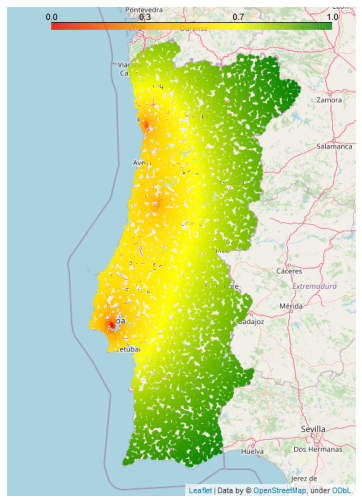

In [86]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(9,9))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/remoteness.png")
plt.imshow(a)
plt.axis('off')
plt.show()

In order to choose the best locations to place our banners, we will rank our random spots by an "attractiveness function", which will be equal to Predicted_daily_views * remoteness. We will place the banners we removed from city centres in the places with the highest attractiveness.


In [58]:
random_points['attractiveness'] = random_points.Predicted_daily_views * random_points.remoteness

In [59]:
to_move = random_points.sort_values('attractiveness', ascending=False).head(250)

In [60]:
x_start = (to_move['Y'].max() + to_move['Y'].min()) / 2
y_start = (to_move['X'].max() + to_move['X'].min()) / 2
start_coord = (x_start, y_start)

lat = list(to_move.Y)
lon = list(to_move.X)

In [61]:
ads_to_remove

PanelID         X          Y Max_Visibi  Average_Da  \
36     4906 -8.429925  40.206943         75     32259.0   
35     4905 -8.429925  40.206943         75     31304.0   
34     4947 -8.430083  40.207451         69     18735.0   
33     1067 -8.429588  40.207490         69     17620.5   
136   24629 -9.136058  38.715382         69     17204.0   
..      ...       ...        ...        ...         ...   
4     23324 -9.132330  38.710175         69      5258.0   
3     23493 -9.134206  38.710056         69      3026.0   
2     24254 -9.133770  38.709762         69      2253.0   
1     24255 -9.133767  38.709761         69      1877.0   
0     23492 -9.134204  38.710054         69      1068.0   

                                         geometry  index  
36   POINT (-938414.9584254868 4896060.400265037)   36.0  
35   POINT (-938414.9584254868 4896060.400265037)   35.0  
34      POINT (-938432.546905032 4896134.4466113)   34.0  
33   POINT (-938377.4437570896 4896140.131294678)   33.0  
136  POINT (-1017021.324417813 4680984.099387572)  136.0  
..                                            ...    ...  
4    POINT (-1016606.325356136 4680241.247512949)    4.0  
3    POINT (-1016815.160720864 4680224.271119615)    3.0  
2    POINT (-1016766.625422878 4680182.329563116)    2.0  
1    POINT (-1016766.291464406 4680182.186905054)    1.0  
0    POINT (-1016814.938081883 4680223.985802322)    0.0  

[250 rows x 7 columns]

In [ ]:
f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[39.658661, -8.067540],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    )
for loc, p in zip(zip(lat, lon), vie):
    folium.Circle(
        location=loc,
        radius=1,
        color='blue',
        #fill_opacity=0.7
    ).add_to(m)
    
for loc, p in zip(zip(list(ads_to_remove.Y), list(ads_to_remove.X)), vie):
    folium.Circle(
        location=loc,
        radius=1,
        color='red',
        #fill_opacity=0.7
    ).add_to(m)
    
m.add_child(colormap)
f.add_child(m)
f

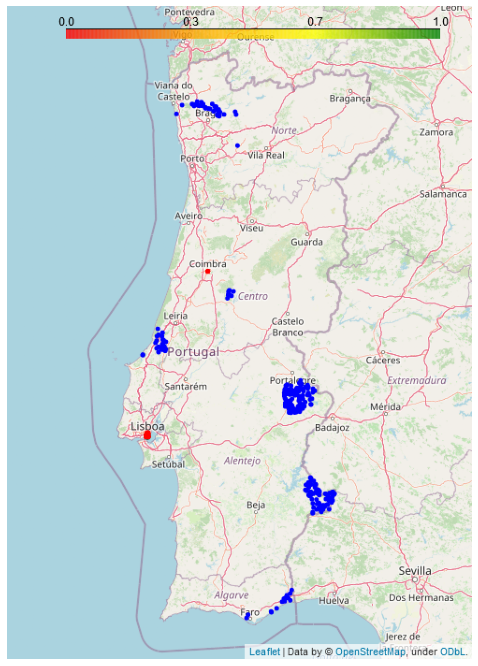

In [87]:
# NOTE: We found that the interactive graphs drawn by the folium library will not appear in submissions. We have replaced them with screenshots.
plt.figure(figsize=(12,12))
a = plt.imread("https://raw.githubusercontent.com/fernandeslouro/wdl-data/main/movements.png")
plt.imshow(a)
plt.axis('off')
plt.show()

Our model essentially porposes the momenment of a number of advertisements from the red spots to the blue spots. Intuitively, these movements do not make a lot of sense, and this is due tho the relative weakness of the model that estimates viewership. Again, this was a very ambitious model to develop and we did not expect great results.

We can also compare total viewership of the moved banners in their original location and their new locations. For that, we simply sum the viewership values and compare. The viewership on the original locations was:

In [65]:
ads_to_remove.Average_Da.sum()

3790389.1666679997

While the viewership in the new locations (in blue) predicted by our model will be:

In [68]:
to_move.Predicted_daily_views.sum()

6312945.012887832

In [69]:
(to_move.Predicted_daily_views.sum()-ads_to_remove.Average_Da.sum())/ads_to_remove.Average_Da.sum()

0.665513680864945

We can see our model predicts that the new locations will have a 66% higher viewership than the original locations. This is very hard to believe, and it stems from the relatively weak results we got from our model. Hiowever, we believe these results can be easily imporved by collecting more data (data from other countries would be equally usable) and computing more and more diverse features for each coordinate.

## Conclusions

### Scalability and Impact

Our goal with this challenge was to develop a fully data-driven approach, and be believe we have succeeded on that front. Each part of our framework can be improved separately, and replaced with different algorithms. The approach we took is very scalable, since it essentially only requires the placement of ads and data about their viewership. It could be used in other countries, and enforced at different levels (neighbourhood, parish, county, etc).

We are aware of the potential impact to advertisers that a limit on the number of ads in cites could bring. The potential economic impact of limiting advertisement can not be understated, and this approach should be tested with very small-impact thresholds at first. Beyond this threshold limit, there are also other approaches that can be taken in order to minimize the ads' impact. Things like reducing their size, uniformizing their placement and shape, and the use of more neutral colors could also help. Nonetheless, we believe the best course of action was to follow a data-driven approach and base ourselves on the data we had.

Having a model of the kind we proposed can also provide strong insigts. We believe another important goal for advertisers to take is to try and make their outdoors as targeted as possible to the people that see them. This way, they can even provide positive value to the people who look at them. A model-based approach, given it is sufficiently comples, could pick up on these opportunities.

### Future Work

Improving the model that predicts viewership would be ne next obvious step. Even with the relatively small number of ads data we now have, we can get a lot of additional feeatures, using paid services like google maps API and Factual's Geosense context API. We can also get data from parishes and neighbourhoods, and add it to any point inside that area.

The limits to the conentration of ads can also be applied in much a more granular manner, at a neighbourhood or even street level, which would make these limits more meaningful and targeted.

Thanks for reading! 😎